# 제주특산물 가격 예측 AI 경진대회 

## Dataset Info.

1. train.csv

- train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
- item: 품목 코드 (TG : 감귤, BC : 브로콜리, RD : 무, CR : 당근, CB : 양배추)
- corporation : 유통 법인 코드 (법인 A부터 F 존재)
- location : 지역 코드 (J : 제주도 제주시, S : 제주도 서귀포시)
- supply(kg) : 유통된 물량, kg 단위
- price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위


2. international_trade.csv

- 관련 품목 수출입 정보 (기간	품목명	수출 중량	수출 금액	수입 중량	수입 금액	무역수지)컬럼으로 구성 


3. test.csv

## 분석 전 생각
기간별로 특산물의 철이 있을거고 가격이 다를 것이라고 생각된다!! 
test셋에는 공급량이 없으니 일단 공급량으로 특산물의철을 파악하고 시계열 그래프를 그려보자 
데이터 파악이후 여러가지 모델을 돌려보면서 가격을 예측해보장 ㅎㅎ !! 
시계열 데이터분석기법등을 살펴보자!! 


 -공급량 + 날짜변수를 통해 철을 구하고 > 데이터프레임을 생성해서 join 해서 사용해보장ㅎㅎ 

In [2]:
## 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
df_test = pd.read_csv('./data/test.csv')
df_test.head()
## 공급량이 없는데..?

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [4]:
# 데이터 다운로드
df_train = pd.read_csv('./data/train.csv')
df_trade = pd.read_csv('./data/international_trade.csv')
df_train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


## 데이터 결측값 및 중복값 확인

In [5]:
## 결측값 확인 >> 없음
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [6]:
## 중복값 확인 >> 없음
df_train[df_train.duplicated()]

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)


In [7]:
df_trade['품목명'].value_counts()

품목명
감귤                                                                               50
포포(papaw)[파파야(papaya)]                                                           50
레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]                               50
그레이프프루트(grapefruit)와 포멜로(pomelo)                                                 50
오렌지                                                                              50
망고(mango)                                                                        50
파인애플                                                                             50
무화과                                                                              50
대추야자                                                                             50
사과                                                                               50
오이류(신선한 것이나 냉장한 것으로 한정한다)                                                        50
당근                                                                      

## 1. EDA

In [8]:
df_train.describe()

,supply(kg),price(원/kg)
count,5.939700e+04,59397.000000
mean,1.189453e+04,1131.680674
std,5.226400e+04,2029.941445
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,3.800000e+03,1519.000000
max,1.222800e+06,20909.000000


In [9]:
df_train['item'].value_counts()

item
TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: count, dtype: int64

In [10]:
df_train['corporation'].value_counts()

corporation
A    13707
E    13707
D    12184
C     9138
B     7615
F     3046
Name: count, dtype: int64

In [11]:
df_train['location'].value_counts()

location
J    35029
S    24368
Name: count, dtype: int64

In [12]:
df_train.groupby('item')[['price(원/kg)']].mean()

,price(원/kg)
item,
BC,910.196615
CB,152.187131
CR,273.118938
RD,187.073539
TG,3177.442022


In [13]:
## 특산물별 평균과 분산
df_train.groupby('item')[['price(원/kg)']].agg(['mean','var'])

price(원/kg)              
             mean           var
item                           
BC     910.196615  2.022506e+06
CB     152.187131  1.190616e+05
CR     273.118938  4.006003e+05
RD     187.073539  1.282716e+05
TG    3177.442022  7.869372e+06

In [14]:
df_train.groupby('location')[['price(원/kg)']].agg(['mean','var'])

price(원/kg)              
                mean           var
location                          
J         1062.35148  3.838061e+06
S         1231.34139  4.510234e+06

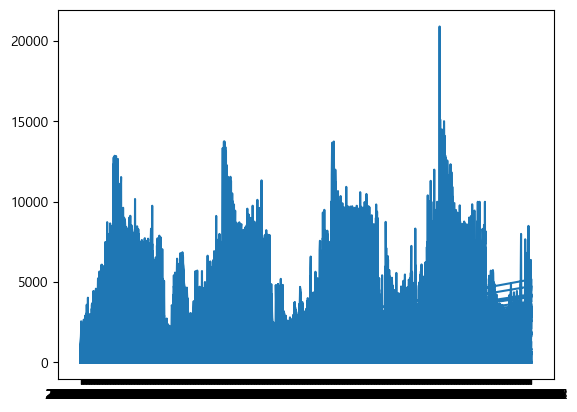

In [27]:
## 시간의 흐름에 따른 감귤 가격 추이
# 년도+월별 평균값 구하기!! ㅎㅎ >> 그래프로 그리기  
df_train

In [19]:
df_train.corr(numeric_only=True) ## 공급량과 가격은 크게 차이나지 않는걸까..?


,supply(kg),price(원/kg)
supply(kg),1.000000,-0.002297
price(원/kg),-0.002297,1.000000


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


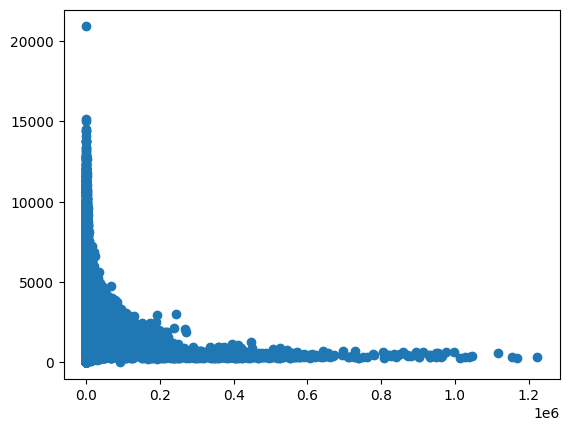

In [24]:
plt.scatter(df_train['supply(kg)'], df_train['price(원/kg)']) > 공급량은 제외할까나.... 